In [1]:
import numpy as np
import matplotlib.pyplot as mpl

from scipy.optimize import root, least_squares


In [121]:
R = 8.3 # J mol-1 K-1
F = 95600 # C mol-1
T = 273 + 32 # Recording temperature

# K+ concentrations :
Ki = 0.13 # M, inside
Krest = 0.0035 # Resting Ko. M., outside

# Na+ concentrations
Ni=0.002 # M, inside
Nrest= 0.150 # Resting M., outside


# Myelin electrical properties
Gm = 60*1e-9 # Membrane total conductance S
El = -0.086# V resting potential
Gg = 540*1e-12 #conductance of the connection with oligo and astrocytes
Gp= 6.3*1e-9# Conductance of the processes
Ga= 30*1e-9 # Conductance of astrocytes membrane S

# Kir parameters
Gk = 9.286*1e-9 #S

#HCN parameters
Gh=0.484*1e-9#S
Eh=-0.03 #V
a = 0.63 #mV-1
b = 0.063  #mV-1
c = 0.079  #mV-1
V_half = -100.0 #mV
gamma_h= 2.6

#ATPase NA+/K+
KmK = 0.005 # M the affinity of the ATPase Na+/K+ for K+
KmNa= 0.01 #M/L
Imax =3.15025237e-11 #A

#Hemichannels leak
Gl=5.65744323e-07
gamma_l= 1.3


#  Stimulation (axonal activity characteristics)
dt = 1e-6 # s, 10 milliseconds of delta t
APefflux = 0.002 # M change in K(submyelin) with AP.
APtimes = np.arange(0,0.2,0.01) # Roughly 20 APs at 10ms intervals. # this mimicks the stimulation in the paper
times = np.arange(0,4,1e-6) #time-window studied


# Axon-myelin properties
Cm = 24*1e-12 # farad #capacitance of the myelin
tau=25.24*1e-3
n_internode =50
Vint = 6e-15 # litres. Volume of the internode peri-axonal space.
l_internode= 5e-5 #m 50um
r_axon= 0.5*1e-6 #m 0.5um
e_myelin = 250*1e-9 #m 250 nm
V_myelin = (((e_myelin+r_axon)**2*np.pi-r_axon**2*np.pi)*l_internode)*1000#en L
e_submyelin = 2*1e-8 #m
V_submyelin = (((e_submyelin+r_axon)**2*np.pi-r_axon**2*np.pi)*l_internode)*1000#en L (bonne estimation par Vint)
l_paranode = 1.9 *1e-6
S_section_submyelin= (e_submyelin+r_axon)**2*np.pi-r_axon**2*np.pi

D= 1.85*1e-9 #diffusion coefficent for K+

In [130]:
def ATPase (Imax, KmK, KmNa, Ke, Ni=Ni):
    F= (1+KmK/Ke)**(-2)+ (1+KmNa/Ni)**(-3)
    Ina= 3*Imax*F
    Ik= -2*Imax*F
    return(Ik, Ina)


def I_KIR(R,T,F,Gk, V, c_ext,c_int):
    """

    :param R:
    :param T:
    :param F:
    :param Gk: conductance of the KIR channels of the internode (S)
    :param V: membrane potential (V)
    :param c_ext: K+ concentration of the external compartment (M)
    :param c_int:  K+ concentration of the internal compartment (M)
    :return:
    """
    EK = E(R,T,F,c_ext,c_int) #calculating the Equilibrium potential for K+ with Nernst Law
    DV=(V - EK)
    return Gk*P_k(R,T,F,V,c_ext, c_int)*np.sqrt(c_ext)* DV

def P_k(R,T,F,V,c_ext,c_int):
    EK = E(R,T,F,c_ext,c_int) #calculating the Equilibrium potential for K+ with Nernst Law
    DV=(V - EK)
    return 1/(1+np.exp((DV+0.015)/0.007))


def E( R,T,F,c_ext,c_int):
    """

    :param R:
    :param T:
    :param F:
    :param c_ext: Ion concentration of the external compartment (M)
    :param c_int: Ion concentration of the internal compartment (M)
    :return: Equilibrium potential of the ion depending on the concentrations
    """
    return (R * T / F) * np.log(c_ext / c_int)



def P_h(a, b, c, V, V_half):
    """

    :param a:(mV-1)
    :param b:(mV-1)
    :param c:(mV-1)
    :param V: membrane potential (V)
    :param V_half: potential of half-activation (V)
    :return: Probability of HCN channels to be open at a given V
    """
    alpha = a * np.exp(-b * (V * 1000 - V_half))
    beta = a * np.exp(c * (V * 1000 - V_half))
    return alpha/(alpha + beta)

def Fgamma_h(Eh,c_ext,c_int,Nrest,Ni):
    EK=E(R,T,F,c_ext,c_int)
    ENa= E(R,T,F,Nrest,Ni)
    return (ENa/Eh-1)/(1-EK/Eh)


def Fgamma_l(c_ext,c_int,Nrest,Ni):
    EK=E(R,T,F,c_ext,c_int)
    ENa= E(R,T,F,Nrest,Ni)
    return -ENa/EK

def Gi(Gm, Gp, Gg,Ga, n_internode):
    return 1/((n_internode/Gm)-1/Gp)-1/((1/Ga)+(1/Gg))

def gap_j_leak(V,gamma_l,Gl,c_ext,c_int,Nrest, Ni ):
    EK=E(R,T,F,c_ext,c_int)
    ENa= E(R,T,F,Nrest,Ni)
    IlK= Gl * (gamma_l/(1+gamma_l))* (V - EK)
    IlNa = Gl * (1 / (1 + gamma_l))  * (V - ENa)
    return IlK, IlNa


def gap_j(R,T,F,myelinK,V,Gg,El,Ki=Ki):
    return Gg*(V-El)/(np.exp(F*(V-El)/(R*T))-1)*(myelinK-Ki*np.exp(F*(V-El)/(R*T)))

def I_H(Ph, Gh,V,gamma_h,c_ext,c_int,Ni,Nrest ):
    """
    :param Ph: probability of HCN channels to be open at a given V
    :param Gh: conductance of the HCN channel in the internode (S)
    :param gamma: permeability ratio between K+ and Na+ (Pk+/PNa+)
    :param V: membrane potential (V)
    :param c_ext: K+ concentration of the external compartment (M)
    :param c_int: K+ concentration of the internal compartment (M)
    :param Ni: Na+ concentration of the internaal compartment (M)
    :param Nrest:Na+ concentration of the external compartment (M)
    :return: Current (in A) based on H-H model
    """
    EK=E(R,T,F,c_ext,c_int)
    ENa= E(R,T,F,Nrest,Ni)
    IhK= Gh * (gamma_h/(1+gamma_h))* Ph  * (V - EK)
    IhNa = Gh * (1 / (1 + gamma_h)) * Ph * (V - ENa)
    return IhK, IhNa #pour l'instant return le courant sortant de K (positif) entraint de Na+ (negatif)

def diffK(D,l_paranode, S,V_submyelin,submyelinK, extK):
    return -(S/V_submyelin)*(D/l_paranode)*(submyelinK-extK)

# At rest

In [116]:
gap_j_leak(El,gamma_l,Gl,Krest,Ki,Nrest,Ni)
ATPase(Imax,KmK,KmNa,Krest,Ni)

(-1.0974206721456489e-11, 1.6461310082184734e-11)

## Estimating the conductances

In [111]:
gamma_l=Fgamma_l(Krest,Ki,Nrest,Ni)
gamma_h=Fgamma_h(Eh,Krest,Ki,Nrest,Ni)
print(gamma_h)


2.1961122941420235


In [ ]:
eq1 =(I_KIR(R,T,F,Gk,El,Krest,Ki)+sum(I_H(P_h(a,b,c,El,V_half),Gh,El,gamma_h,Krest,Ki,Ni,Nrest))+sum(ATPase(Imax, KmK,KmNa,Krest,Ni))+sum(gap_j_leak(El,gamma_l,Gl,Krest,Ki,Nrest,Ni))) #null current at rest (no capacitive current)
    eq2 = (I_KIR(R,T,F,Gk,El,Krest,Ki)+I_H(P_h(a,b,c,El,V_half),Gh,El,gamma_h,Krest,Ki,Ni,Nrest)[0]+ATPase(Imax, KmK,KmNa,Krest,Ni)[0]+gap_j_leak(El,gamma_l,Gl,Krest,Ki,Nrest,Ni)[0])/(V_myelin*F) # equilibrium for K+ concentration
 #   eq3 = (I_H(P_h(a,b,c,El,V_half),Gh,El,gamma_h,Krest,Ki,Ni,Nrest)[1]+ATPase(Imax, KmK,KmNa,Krest,Ni)[1]+gap_j_leak(El,gamma_l,Gl,Krest,Ki,Nrest,Ni)[1])/(V_myelin*F) #equilibrium for Na+


    #eq4 = Gi(Gm,Gp,Gg,Ga,n_internode) - Gk*P_k(R,T,F,El,Krest,Ki)*np.sqrt(Krest) -Gh*P_h(a,b,c,El,V_half)-Gl#the conductance sum equals the total conductance of the internode


In [132]:

from scipy.optimize import fsolve

def equations(vars):
    Gl,Imax = vars
    eq1 =(I_KIR(R,T,F,Gk,El,Krest,Ki)+sum(I_H(P_h(a,b,c,El,V_half),Gh,El,gamma_h,Krest,Ki,Ni,Nrest))+sum(ATPase(Imax, KmK,KmNa,Krest,Ni))+sum(gap_j_leak(El,gamma_l,Gl,Krest,Ki,Nrest,Ni))) #null current at rest (no capacitive current)
    eq2 = (I_KIR(R,T,F,Gk,El,Krest,Ki)+I_H(P_h(a,b,c,El,V_half),Gh,El,gamma_h,Krest,Ki,Ni,Nrest)[0]+ATPase(Imax, KmK,KmNa,Krest,Ni)[0]+gap_j_leak(El,gamma_l,Gl,Krest,Ki,Nrest,Ni)[0])/(V_myelin*F) # equilibrium for K+ concentration
 #   eq3 = (I_H(P_h(a,b,c,El,V_half),Gh,El,gamma_h,Krest,Ki,Ni,Nrest)[1]+ATPase(Imax, KmK,KmNa,Krest,Ni)[1]+gap_j_leak(El,gamma_l,Gl,Krest,Ki,Nrest,Ni)[1])/(V_myelin*F) #equilibrium for Na+


    #eq4 = Gi(Gm,Gp,Gg,Ga,n_internode) - Gk*P_k(R,T,F,El,Krest,Ki)*np.sqrt(Krest) -Gh*P_h(a,b,c,El,V_half)-Gl#the conductance sum equals the total conductance of the internode

    return [ eq1,eq2]


initial_guess = [1e-11,1e-11]
solution = root(
    equations,
    initial_guess,
    tol=1e-16
)
Gl,Imax  = solution.x

In [134]:
print(solution.x)

[-3.04710332e-11  1.13020752e-12]


In [ ]:
Gk_e=Gk*np.sqrt(Krest)*(P_k(R,T,F,El,Krest,Ki)-((El-E(R,T,F,Krest,Ki))/0.007)*P_k(R,T,F,El,Krest,Ki)*(1-P_k(R,T,F,El,Krest,Ki)))
Gh_e=Gh*(P_h(a,b,c,El,V_half)-1000*(b+c)*P_h(a,b,c,El,V_half)*(1-P_h(a,b,c,El,V_half))*(gamma_h/(1+gamma_h)* (El - E(R,T,F,Krest,Ki))+1 / (1 + gamma_h) * (El - E(R,T,F,Nrest,Ni))))

In [91]:
Gi(Gm,Gp,Gg,Ga,n_internode) - Gk*P_k(R,T,F,El,Krest,Ki)*np.sqrt(Krest) -Gh*P_h(a,b,c,El,V_half)

np.float64(8.779742913479136e-10)

## Looking at evolution of K+ concentration and current

In [98]:
submyelinK = np.full(len(times), Krest)
myelinK = np.full(len(times), Ki)
I=np.full(len(times),0.0)
IKIR=np.full(len(times),0.0)
IHCN=np.full(len(times),0.0)
IATP=np.full(len(times),0.0)
IL=np.full(len(times),0.0)

In [99]:
Imax=1.54565401e-10

In [100]:
for i in range(len(times)-1):
     #on aligne la concentration au pas de temps précedent
    myelinK[i+1]=myelinK[i]
    submyelinK[i+1]=submyelinK[i]
    #Les courants

    atpase_current=ATPase(Imax,KmK,KmNa,submyelinK[i],Ni)
    IATP[i]=sum(atpase_current)

    ikir= I_KIR(R,T,F,Gk,El,submyelinK[i],myelinK[i])
    IKIR[i]=ikir
    ihcn= I_H(P_h(a,b,c,El,V_half),Gh,El,gamma_h,submyelinK[i],myelinK[i])
    IHCN[i]=sum(ihcn)

    ileak= gap_j_leak(El,gamma_l,Gl,submyelinK[i],myelinK[i],Ni,Nrest)
    IL[i]=sum(ileak)

    I[i]= sum(atpase_current)+ikir+sum(ihcn)+sum(ileak)

   #Les concentrations K+
    atpase_current_K=atpase_current[1]
    myelinK[i+1] -=  atpase_current_K*dt/(F*V_myelin)
    submyelinK[i+1]+=atpase_current_K*dt/(F*V_submyelin)

    myelinK[i+1]-= ikir * dt / (V_myelin * F)
    submyelinK[i+1]+= ikir * dt / (V_submyelin * F)

    ihcn_k= ihcn[0]
    myelinK[i+1]-= ihcn_k* dt / (V_myelin * F)
    submyelinK[i+1]+= ihcn_k* dt / (V_submyelin * F)

    ileak_k=ileak[0]
    myelinK[i+1]-= ileak_k* dt / (V_myelin * F)
    submyelinK[i+1]+= ileak_k* dt / (V_submyelin * F)




In [103]:
ATPase(Imax,KmK,KmNa,Krest,Ni)

(-5.384434208230807e-11, 8.07665131234621e-11)

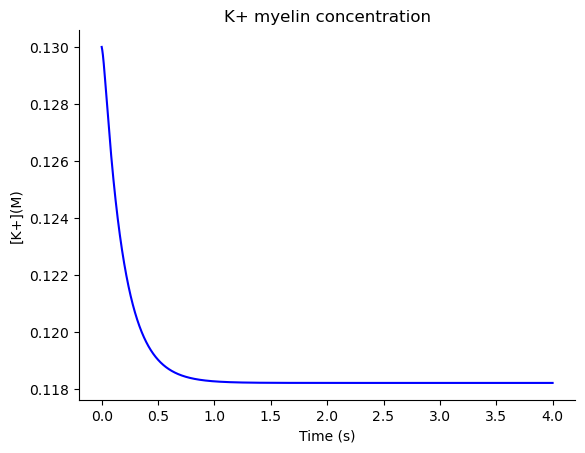

In [101]:
fig,ax=mpl.subplots()
mpl.plot(times, myelinK,color='blue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("[K+](M)")
mpl.title("K+ myelin concentration")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
mpl.show()

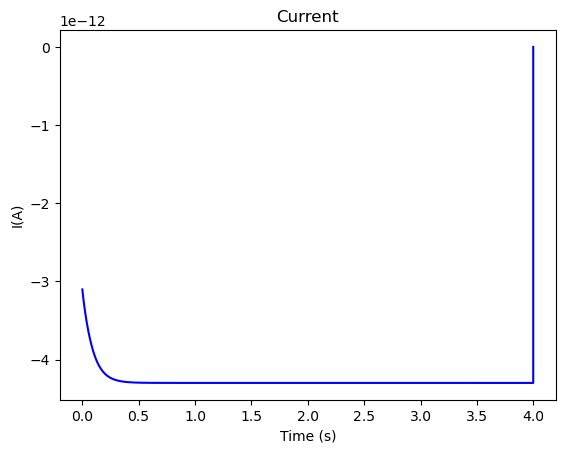

In [90]:
fig,ax=mpl.subplots()
mpl.plot(times, IHCN,color='blue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("I(A)")
mpl.title("Current")
mpl.show()

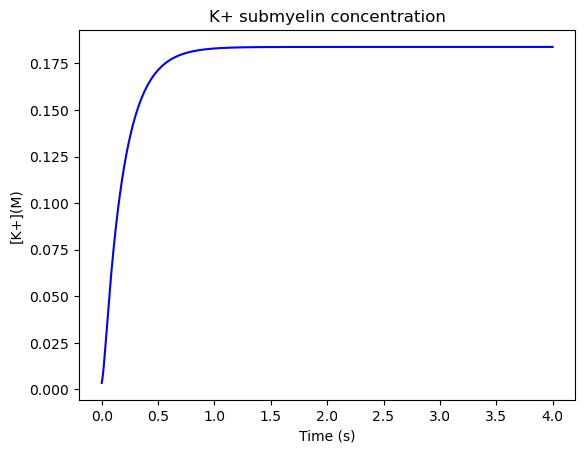

In [102]:
fig,ax=mpl.subplots()
mpl.plot(times, submyelinK,color='blue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("[K+](M)")
mpl.title("K+ submyelin concentration")
mpl.show()

In [6]:
submyelinK = np.full(len(times), Krest)
myelinK = np.full(len(times), Ki)
extK = np.full(len(times),Krest)
atpase_current_K=np.full(len(times),0.)
IKIR_s=np.full(len(times),0.0)
IHCN_s=np.full(len(times),0.0)
IATP_s=np.full(len(times),0.0)

IKIR_e=np.full(len(times),0.0)
IHCN_e=np.full(len(times),0.0)
IATP_e=np.full(len(times),0.0)

EK_s=np.full(len(times),0.)
EK_e=np.full(len(times),0.)

V=np.full(len(times),El)

In [8]:
for i in range(len(times)-1):

    submyelinK[i+1]=submyelinK[i] #on aligne la concentration au pas de temps précedent
    myelinK[i+1]=myelinK[i]

    #AP efflux

    if sum(APtimes < (times[i] - dt)) < sum(APtimes < times[i]):  #meaning that the t+dt is reaching the timing of a new AP
        submyelinK[i + 1] += APefflux  # addition of K+ efflux from the neuronal activity


    #interface submyelin

     #Les courants
    atpase_current=ATPase(Imax/20,KmK,KmNa,submyelinK[i],Ni)
    IATP_s[i]=sum(atpase_current)

    ikir= I_KIR(R,T,F,Gk/20,V[i],submyelinK[i],myelinK[i])
    IKIR_s[i]=ikir
    ihcn= I_H(P_openH(a,b,c,V[i],V_half),Gh/20,V[i],gamma,submyelinK[i],myelinK[i])
    IHCN_s[i]=sum(ihcn)


   #Les concentrations K+
    atpase_current_K=atpase_current[1]
    myelinK[i+1] -=  atpase_current_K*dt/(F*V_myelin)
    submyelinK[i+1]+=atpase_current_K*dt/(F*V_submyelin)

    myelinK[i+1]-= ikir * dt / (V_myelin * F)
    submyelinK[i+1]+= ikir * dt / (V_submyelin * F)

    ihcn_k= ihcn[0]
    myelinK[i+1]-= ihcn_k* dt / (V_myelin * F)
    submyelinK[i+1]+= ihcn_k* dt / (V_submyelin * F)

    EK_s[i]=E(R,T,F,submyelinK[i],myelinK[i])
    EK_e[i]=E(R,T,F,Krest,myelinK[i])

  #  V[i + 1] = V[i] + dt / Cm * ( - IKIR_s[i] - IHCN_s[i]-IATP_s[i])




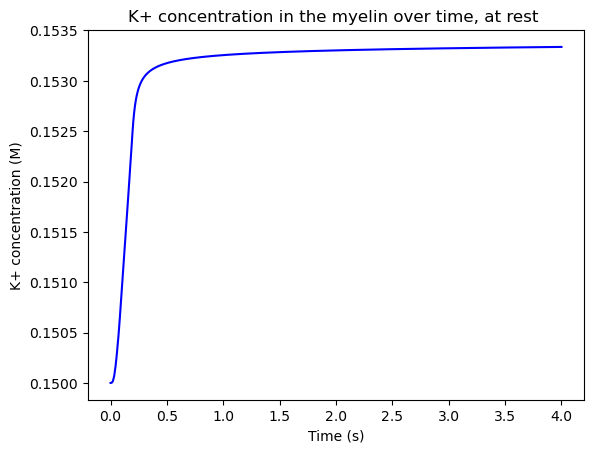

In [9]:

fig,ax=mpl.subplots()
mpl.plot(times, myelinK,color='blue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("K+ concentration (M)")
mpl.title("K+ concentration in the myelin over time, at rest ")
mpl.show()


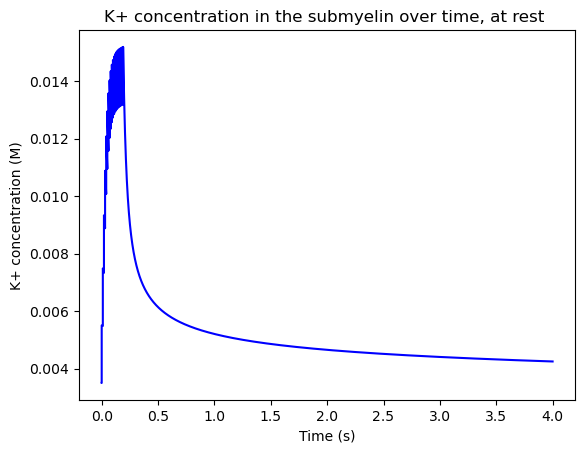

In [10]:
fig,ax=mpl.subplots()
mpl.plot(times, submyelinK,color='blue')
ax.set_xlabel("Time (s)")
ax.set_ylabel("K+ concentration (M)")
mpl.title("K+ concentration in the submyelin over time, at rest ")
mpl.show()

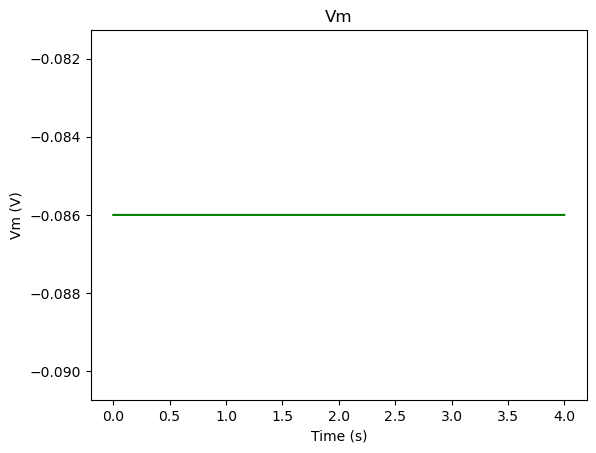

In [11]:

fig,ax=mpl.subplots()
mpl.plot(times, V,color='green')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vm (V)")
mpl.title("Vm")
mpl.show()


In [12]:
for i in range(len(times)-1):

    submyelinK[i+1]=submyelinK[i] #on aligne la concentration au pas de temps précedent
    myelinK[i+1]=myelinK[i]

    #AP efflux

    if sum(APtimes < (times[i] - dt)) < sum(APtimes < times[i]):  #meaning that the t+dt is reaching the timing of a new AP
        submyelinK[i + 1] += APefflux  # addition of K+ efflux from the neuronal activity


    #interface submyelin

     #Les courants
    atpase_current=ATPase(Imax/20,KmK,KmNa,submyelinK[i],Ni)
    IATP_s[i]=sum(atpase_current)

    ikir= I_KIR(R,T,F,Gk/20,V[i],submyelinK[i],myelinK[i])
    IKIR_s[i]=ikir
    ihcn= I_H(P_openH(a,b,c,V[i],V_half),Gh/20,V[i],gamma,submyelinK[i],myelinK[i])
    IHCN_s[i]=sum(ihcn)


   #Les concentrations K+
    atpase_current_K=atpase_current[1]
    myelinK[i+1] -=  atpase_current_K*dt/(F*V_myelin)
    submyelinK[i+1]+=atpase_current_K*dt/(F*V_submyelin)

    myelinK[i+1]-= ikir * dt / (V_myelin * F)
    submyelinK[i+1]+= ikir * dt / (V_submyelin * F)

    ihcn_k= ihcn[0]
    myelinK[i+1]-= ihcn_k* dt / (V_myelin * F)
    submyelinK[i+1]+= ihcn_k* dt / (V_submyelin * F)



    #interface ext

     #Les courants
    atpase_current=ATPase(Imax/20,KmK,KmNa,Krest,Ni)
    IATP_e[i]=sum(atpase_current)

    ikir= I_KIR(R,T,F,Gk/20,V[i],Krest,myelinK[i])
    IKIR_e[i]=ikir
    ihcn= I_H(P_openH(a,b,c,V[i],V_half),Gh/20,V[i],gamma,Krest,myelinK[i])
    IHCN_e[i]=sum(ihcn)


   #Les concentrations K+
    atpase_current_K=atpase_current[1]
    myelinK[i+1] -=  atpase_current_K*dt/(F*V_myelin)

    myelinK[i+1]-= ikir * dt / (V_myelin * F)

    ihcn_k= ihcn[0]
    myelinK[i+1]-= ihcn_k* dt / (V_myelin * F)


    # Axonal K+ uptake

    #axon_atpasecurrent=ATPase(Imax_a,KmK,KmNa,submyelinK[i],Ni)
    #submyelinK[i+1]+=axon_atpasecurrent[1]*dt/(F*V_submyelin)

    #Radial diffusion
    submyelinK[i+1]+= dt*diffK(D,l_paranode,S_section_submyelin,V_submyelin, submyelinK[i], Krest)

    #Voltage

    V[i + 1] = V[i] + dt / Cm * ( - IKIR_s[i] - IHCN_s[i]-IATP_s[i]-IKIR_e[i] - IHCN_e[i]-IATP_e[i])



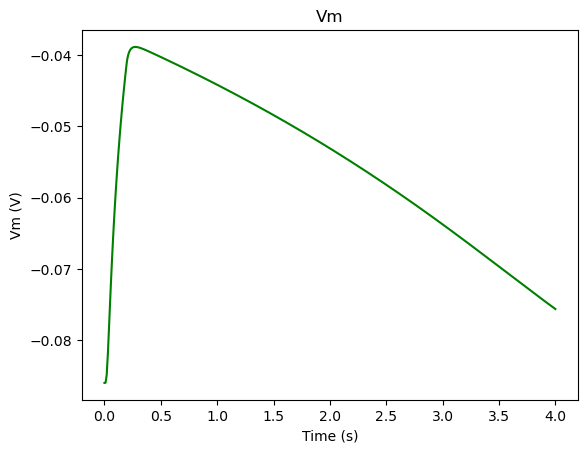

In [13]:
fig,ax=mpl.subplots()
mpl.plot(times, V,color='green')
ax.set_xlabel("Time (s)")
ax.set_ylabel("Vm (V)")
mpl.title("Vm")
mpl.show()

In [27]:
fig,ax=mpl.subplots()
mpl.plot(times, IHCN_e,color='red',label="external interface")
mpl.plot(times, IHCN_s,color='darkred', label='submyelin interface')
ax.set_xlabel("Time (s)")
ax.set_ylabel("I (A)")
mpl.title("HCN current  over time ")
mpl.legend()
mpl.show()

/Users/lounaschaison/miniforge3/envs/basepython/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


KeyboardInterrupt: 

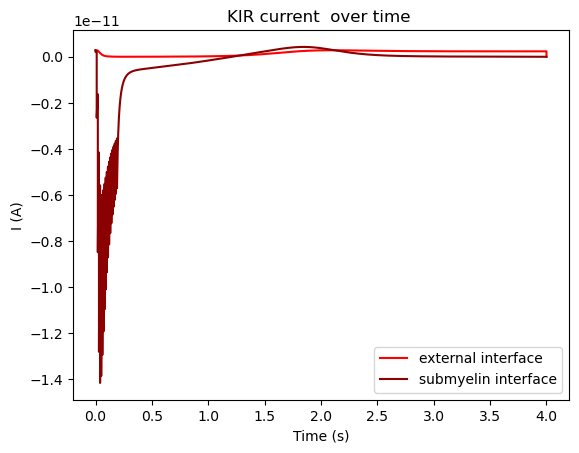

In [28]:
fig,ax=mpl.subplots()
mpl.plot(times, IKIR_e,color='red',label="external interface")
mpl.plot(times, IKIR_s,color='darkred', label='submyelin interface')
ax.set_xlabel("Time (s)")
ax.set_ylabel("I (A)")
mpl.title("KIR current  over time ")
mpl.legend()
mpl.show()

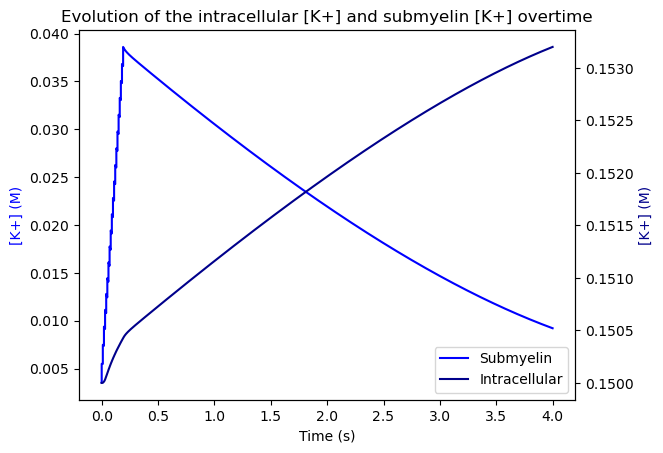

In [14]:

fig, ax1 = mpl.subplots()

line1 = ax1.plot(times, submyelinK, color='blue', label="Submyelin")
ax1.set_xlabel("Time (s)")
ax1.set_ylabel("[K+] (M)",color='blue')
ax2 = ax1.twinx()
line2 = ax2.plot(times, myelinK, color='darkblue', label="Intracellular")
ax2.set_ylabel("[K+] (M)",color='darkblue')

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='lower right')

mpl.title("Evolution of the intracellular [K+] and submyelin [K+] overtime")

mpl.show()

## Taking into account the connection with astoryctes and oligo through gap junctions

In [ ]:
for i in range(len(times)-1):

    submyelinK[i+1]=submyelinK[i] #on aligne la concentration au pas de temps précedent
    myelinK[i+1]=myelinK[i]

    #AP efflux

    if sum(APtimes < (times[i] - dt)) < sum(APtimes < times[i]):  #meaning that the t+dt is reaching the timing of a new AP
        submyelinK[i + 1] += APefflux  # addition of K+ efflux from the neuronal activity


    #interface submyelin

     #Les courants
    atpase_current=ATPase(Imax/20,KmK,KmNa,submyelinK[i],Ni)
    IATP_s[i]=sum(atpase_current)

    ikir= I_KIR(R,T,F,Gk/20,V[i],submyelinK[i],myelinK[i])
    IKIR_s[i]=ikir
    ihcn= I_H(P_openH(a,b,c,V[i],V_half),Gh/20,V[i],gamma,submyelinK[i],myelinK[i])
    IHCN_s[i]=sum(ihcn)


   #Les concentrations K+
    atpase_current_K=atpase_current[1]
    myelinK[i+1] -=  atpase_current_K*dt/(F*V_myelin)
    submyelinK[i+1]+=atpase_current_K*dt/(F*V_submyelin)

    myelinK[i+1]-= ikir * dt / (V_myelin * F)
    submyelinK[i+1]+= ikir * dt / (V_submyelin * F)

    ihcn_k= ihcn[0]
    myelinK[i+1]-= ihcn_k* dt / (V_myelin * F)
    submyelinK[i+1]+= ihcn_k* dt / (V_submyelin * F)



    #interface ext

     #Les courants
    atpase_current=ATPase(Imax/20,KmK,KmNa,Krest,Ni)
    IATP_e[i]=sum(atpase_current)

    ikir= I_KIR(R,T,F,Gk/20,V[i],Krest,myelinK[i])
    IKIR_e[i]=ikir
    ihcn= I_H(P_openH(a,b,c,V[i],V_half),Gh/20,V[i],gamma,Krest,myelinK[i])
    IHCN_e[i]=sum(ihcn)


   #Les concentrations K+
    atpase_current_K=atpase_current[1]
    myelinK[i+1] -=  atpase_current_K*dt/(F*V_myelin)

    myelinK[i+1]-= ikir * dt / (V_myelin * F)

    ihcn_k= ihcn[0]
    myelinK[i+1]-= ihcn_k* dt / (V_myelin * F)


    # GAP junctions
    Ig=gap_j(R,T,F,myelinK[i],V[i],Gg,El,Ki)
    myelinK[i+1]+=  Ig* dt / (V_myelin * F)


    V[i + 1] = V[i] + dt / Cm * ( - IKIR_s[i] - IHCN_s[i]-IATP_s[i]-IKIR_e[i] - IHCN_e[i]-IATP_e[i])


/var/folders/1p/_vl7gjxs3597kgq9c69yxz0h0000gn/T/ipykernel_11811/659603085.py:63: RuntimeWarning: invalid value encountered in scalar divide
  return Gg*(V-El)/(np.exp(F*(V-El)/(R*T))-1)*(myelinK-Ki*np.exp(F*(V-El)/(R*T)))


In [30]:
gap_j(R,T,F,Krest,-0.04,Gg,El,Ki)

np.float64(-4.503387588297705e-12)